VAE test versions. 

Options (important note: for all of these that reconstruction loss is multiplied by img_dim^2)
Loss can be "mse" or "xent"

Basic VAE 
    "vanilla": Loss = Reconstruction_loss + KL_loss

Controlled capacity increase 
    "cc": Loss = Reconstruction_loss + gamma(KL_loss - C)

Beta
    "beta": Loss = Reconstruction_loss + beta|(KL_loss - C)|

Decomposition
    "d": Loss = Reconstruction_loss + beta(KL_loss) + alpha(Divergence)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import norm
import os
import cv2
import pandas as pd

import pickle
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

import tensorflow as tf

import keras
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras import regularizers
from keras.initializers import RandomNormal
from keras.optimizers import RMSprop, Adam
from keras.models import load_model
from keras.callbacks import Callback
from keras import layers
from keras import metrics

import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

%matplotlib inline


Using TensorFlow backend.


In [2]:
# functions
def rgb2gray(rgba, img_dim, crop):
    """Returns scaled, cropped (and grayscale) image array
    """
    img = rgba[crop:-crop, crop:-crop]
    img = cv2.resize(img, dsize=(img_dim, img_dim),interpolation=cv2.INTER_CUBIC)
    if len(img.shape) == 3:
        if img.shape[2] == 4:
            img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    return(img)


def openimg(fn):
    """Returns image array from filename and isValid result 
    """
    try:
        with open(fn, 'rb') as handle:
            img = pickle.load(handle, encoding='latin1')
            isValid = True
    except Exception as e:
        print(e)
        img = []
        isValid = False
    return(img, isValid)


def save_obj(obj, fname):
    """Pickles object to file location
    """
    with open(fname + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    return()


def openImgFile(imgdir, indexfn, pathstr, frac, img_dim, crop, nplot, hack):
    """Opens and returns image files as array and index file dataframe 
    """
    if hack:
        num_images = len(os.listdir(imgdir))
        raw = np.zeros((num_images, img_dim*img_dim))
        df = []
        for i, fn in enumerate(os.listdir(imgdir)):
            img = mpimg.imread(os.path.join(imgdir,fn)) 
            result = True
            if result:
                img = rgb2gray(img, img_dim, crop)
                #scale between 0 and 1
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                fimg = img.flatten()
                raw[i,:,] = fimg
                if i % nplot == 0:
                    plt.imshow(img, cmap=plt.get_cmap('gray'))
                    plt.show()
        return(raw, df, num_images)
    else:     
        with open(os.path.join(imgdir, indexfn), 'rb') as handle:
            df = pickle.load(handle, encoding='latin1')

        num_images = len(df)//frac

        df['filename'] = df['filename'].str.replace(pathstr, imgdir)
        df = df[0:num_images]

        raw = np.zeros((num_images, img_dim*img_dim))

        for i in range(num_images):
            fn = df.filename.iloc[i]
            img, result = openimg(fn)  
            if result:
                img = rgb2gray(img, img_dim, crop)
                #scale between 0 and 1
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                fimg = img.flatten()
                raw[i,:,] = fimg
                if i % nplot == 0:
                    plt.imshow(img, cmap=plt.get_cmap('gray'))
                    plt.title("sample {} numBatches {}".format(i,df.numBatches[i]))
                    plt.show()
        return(raw, df, num_images)


def makeTrainValdata(raw_x, df, preds, img_dim, split):
    """Returns test and validation datasets from index, predictor list and image array 
    """
    y = np.array(df[preds].values)
    num_predictors =  y.shape[1]
    X = raw_x.reshape((raw_x.shape[0], img_dim, img_dim, 1))
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=split)
    return(num_predictors, x_train, x_test, y_train, y_test)
    

def rsq(x, y):
    """ Return R^2 where x and y are array-like.
    """
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x.astype(float), y)
    return r_value**2


def create_predictor(d1, d2):
    '''Creates a regressor that estimates c values from latent z variables.
    '''
    predictor_input = layers.Input(shape=(d1,))
    x = layers.Dense(128, activation='relu')(predictor_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(d2, activation='linear')(x)
    return Model(predictor_input, x)


In [3]:
# custom classes

class CapacityIncrease(Callback):
    '''Creates custom callback object for increasing capacity
    '''    
    def __init__(self, max_capacity, max_epochs):
        self.max_capacity = max_capacity
        self.current_capacity = 0
        self.max_epochs = max_epochs
        super(Callback).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.max_epochs:
            self.current_capacity = self.max_capacity * epoch / self.max_epochs
        else:
            self.current_capacity = self.max_capacity
        print("Updated vae capacity param: ", self.current_capacity)
        vae.max_capacity = self.current_capacity

        
class vaeModel(object):
    '''Creates vae model object
    '''
    def __init__(self, alpha, beta, gamma, lr, capacity, img_shape, latent_dim, filters, vae_type="beta", loss = "xent"):
        # Model
        self.model = self.build_model()
        # Print a model summary
        self.model.summary()
        self.optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
        self.loss_func = self.model_loss()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.vae_type = vae_type
        self.reg = img_shape[0]*img_shape[1]
        #self.capacity = capacity
        self.built = True
        super(Layer).__init__()

    def model_loss(self):
        """" Wrapper function which calculates auxiliary values for the complete loss function.
        Returns a *function* which calculates the complete loss given only the input and target output 
        """
        # KL loss
        kl_loss = self.L_KL
        # cross-entropy reconstruction loss
        xent_loss_func = self.L_XENT
        # mse reconstruction loss
        mse_loss_func = self.L_MSE
        # KL D loss
        kl_d_loss_func = self.L_KL_D
        
        #self.max_capacity = capacity
        #max_capacity = self.max_capacity
        
        def seq2seq_loss(x, z_decoded):
            """ Final loss calculation function to be passed to optimizer
            """
            # Reconstruction loss
            if loss_type == "xent":
                r_loss = xent_loss_func(x, z_decoded)
            else:
                r_loss = mse_loss_func(x, z_decoded)
            
            # decomposition loss
            kl_d_loss = kl_d_loss_func()
            
            # Full loss
            if self.vae_type == "beta":
                model_loss = K.mean(r_loss + self.beta * kl_loss())
            elif self.vae_type == "cc":
                model_loss = K.mean(r_loss + self.gamma * K.abs(kl_loss() - self.capacity))
            elif self.vae_type == "d":
                model_loss = K.mean(r_loss + self.beta * kl_loss() + self.alpha * kl_d_loss)
            elif self.vae_type == "vanilla":
                model_loss = K.mean(r_loss + kl_loss())
            return model_loss

        return(seq2seq_loss)
    
    def L_KL(self, *args, **kwargs):
        '''KL loss function
        '''
        kl_loss = 1 + self.z_log_sigma - K.square(self.z_mu) - K.exp(self.z_log_sigma)
        kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
        return(kl_loss/self.reg)
    
    def L_KL_D(self, *args, **kwargs):
        '''KL D loss function
        '''
        # expectation of mu (mean of distributions)
        exp_mu = tf.reduce_mean(self.z_mu, axis=0)
        # expectation of mu mu.tranpose
        mu_expand1 = tf.expand_dims(self.z_mu, 1)
        mu_expand2 = tf.expand_dims(self.z_mu, 2)
        exp_mu_mu_t = tf.reduce_mean(mu_expand1 * mu_expand2, axis=0)
        # covariance of model mean
        cov = exp_mu_mu_t - tf.expand_dims(exp_mu, 0) * tf.expand_dims(exp_mu, 1)
        diag_part = tf.diag_part(cov)
        off_diag_part = cov - tf.diag(diag_part)
        regulariser_od = tf.reduce_sum(off_diag_part**2)
        regulariser_d = tf.reduce_sum((diag_part - 1)**2)
        ## overall loss
        dip_vae_regulariser = regulariser_d + regulariser_od
        return(-0.5 * dip_vae_regulariser/self.reg)

    def L_XENT(self, x, z_decoded):
        '''cross entropy loss
        '''
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        return(xent_loss)
    
    def L_MSE(self, x, z_decoded):
        '''mean square error loss
        '''
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        mse_loss = keras.metrics.mse(x, z_decoded)
        return(mse_loss)
    
    def sampling(self, z_params):
        '''Gets a list of [mu, sigma] and returns a random tensor 
        from the corresponding normal distribution 
        '''
        mu, sigma = z_params
        epsilon = K.random_normal(shape=(K.shape(mu)[0], latent_dim), mean=0.0, stddev=1.0)
        return(mu + K.exp(sigma) * epsilon)
        
    def build_model(self):
        '''Build the model
        '''
        ## Encoder 
        input_img = keras.Input(shape=img_shape)
        x = layers.Conv2D(filters*1, 3,padding='same', activation='relu')(input_img)
        x = layers.Conv2D(filters*1, 3,padding='same', activation='relu',strides=(2, 2))(x)
        x = layers.Conv2D(filters*2, 3,padding='same', activation='relu')(x)
        x = layers.Conv2D(filters*2, 3,padding='same', activation='relu',strides=(2, 2))(x)
        x = layers.Conv2D(filters*4, 3,padding='same', activation='relu')(x)
        x = layers.Conv2D(filters*4, 3,padding='same', activation='relu',strides=(2, 2))(x)
        x = layers.Conv2D(filters*8, 3,padding='same', activation='relu')(x)
        # need to know the shape of the network here for the decoder
        shape_before_flattening = K.int_shape(x)
        x = layers.Flatten()(x)
        # dense layer
        x = layers.Dense(32, activation='relu')(x)
        # sampling layer 
        self.z_mu = layers.Dense(latent_dim)(x)
        self.z_log_sigma = layers.Dense(latent_dim)(x)
        # encoder model statement
        self.encoder = Model(input_img, self.z_mu)
    
        ## Decoder 
        z = layers.Lambda(self.sampling)([self.z_mu, self.z_log_sigma])
        decoder_input = layers.Input(K.int_shape(z)[1:])
        # Expand to img_dim**2 total pixels
        x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
        # reshape
        x = layers.Reshape(shape_before_flattening[1:])(x)
        # use Conv2DTranspose to reverse the conv layers from the encoder
        x = layers.Conv2DTranspose(filters*1, 3,padding='same',activation='relu',strides=(2, 2))(x)
        x = layers.Conv2DTranspose(filters*2, 3,padding='same',activation='relu',strides=(2, 2))(x)
        x = layers.Conv2DTranspose(filters*4, 3,padding='same',activation='relu',strides=(2, 2))(x)
        # Output layer
        x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)
        # decoder model statement
        self.decoder = Model(decoder_input, x)

        ##VAE
        z_decoded = self.decoder(z)
        # VAE model statement
        model_o = Model(input_img, z_decoded)
        
        return model_o
    
    def compile(self):
        '''Compiles the Keras model. Includes metrics to differentiate between the two main loss terms
        '''
        metrics = [self.L_KL]
        
        if vae_type == "d":
            metrics.append(self.L_KL_D)
        
        if loss_type == "xent":
            metrics.append(self.L_XENT)
        elif loss_type == "mse":
            metrics.append(self.L_MSE)
            
        self.model.compile(optimizer=self.optimizer, loss=self.loss_func, metrics=metrics)
        print("beta = ", self.beta)

        print('Model Compiled!')
        
# def sampling(args):
#     """
#     Sampling function
#     """
#     mu, sigma = args
#     epsilon = K.random_normal(shape=(K.shape(mu)[0], latent_dim),
#                               mean=0., stddev=1.)
#     return(mu + K.exp(sigma) * epsilon)
        
# class KLWeightScheduler(Callback):
#     """KL weight scheduler.

#     # Arguments
#         kl_weight: The tensor withholding the current KL weight term
#         schedule: a function that takes a batch index as input
#             (integer, indexed from 0) and returns a new learning rate as output (float).
#         verbose: int. 0: quiet, 1: update messages.
#     """

#     def __init__(self, kl_weight, schedule, verbose=0):
#         super(KLWeightScheduler, self).__init__()
#         self.schedule = schedule
#         self.verbose = verbose
#         self.kl_weight = kl_weight
#         self.count = 0  # Global batch index (the regular batch argument refers to the batch index within the epoch)

#     def on_batch_begin(self, batch, logs=None):

#         new_kl_weight = self.schedule(self.count)
#         if not isinstance(new_kl_weight, (float, np.float32, np.float64)):
#             raise ValueError('The output of the "schedule" function '
#                              'should be float.')
#         # Set new value
#         K.set_value(self.kl_weight, new_kl_weight)
#         if self.verbose > 0 and self.count % 20 == 0:
#             print('\nBatch %05d: KLWeightScheduler setting KL weight '
#                   ' to %s.' % (self.count + 1, new_kl_weight))
#         self.count += 1

In [34]:
# Set key parameters

# image dimension per single axis (images are square)
img_dim = 128
img_shape = (img_dim, img_dim, 1)   


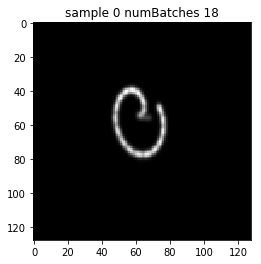

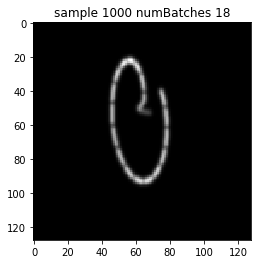

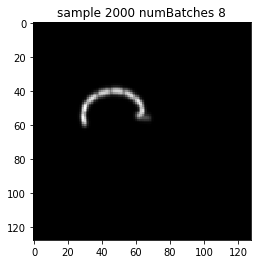

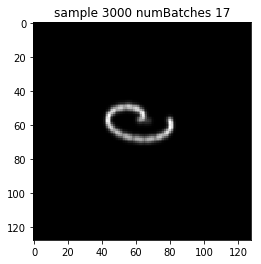

[Errno 2] No such file or directory: '../input/vae09btvdds/vaetest09/3890.csv'


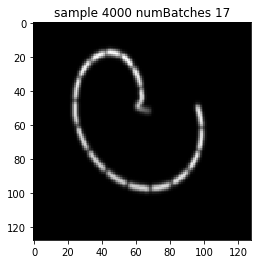

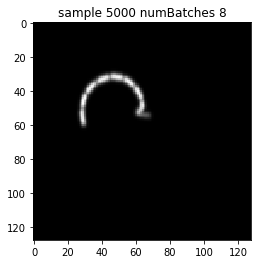

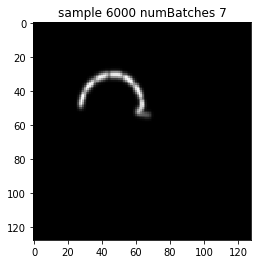

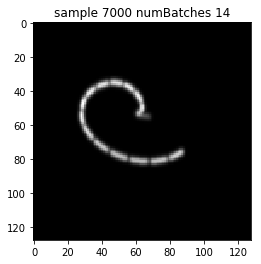

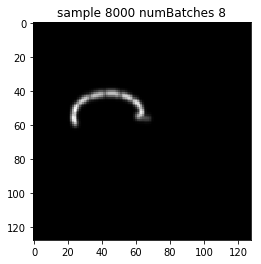

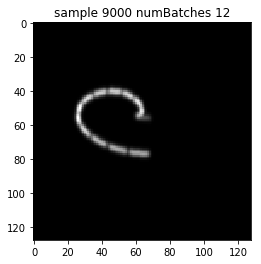

[Errno 2] No such file or directory: '../input/vae09btvdds/vaetest09/9632.csv'


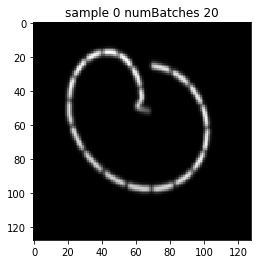

(9000, 128, 128, 1) (9000, 3)
(12, 128, 128, 1) (12, 3)


In [35]:
#open data files for training and validation
raw_x, df, num_images = openImgFile(
    "../input/vae09btvdds/vaetest09", 
    "index08.df", 
    "../../BTVDD_images/VAEtest09", 
    1, img_dim, 10, 1000, hack=False)

#open data files for calibration
calraw_x, caldf, calnum_images = openImgFile(
    "../input/cal01btvdd/cal01", 
    "CALindex01.df", 
    "../../BTVDD_images/CAL01",
    1, img_dim, 10, 20, hack = False)

# raw_x, df, num_images = openImgFile(
#     "../goddard/Desktop/VAEtest09local", 
#     "index08.df", 
#     "../../BTVDD_images/VAEtest09", 
#     10, img_dim, 10, 1000, hack=False)

# #open data files for calibration
# calraw_x, caldf, calnum_images = openImgFile(
#     "../goddard/Desktop/CAL01", 
#     "CALindex01.df", 
#     "../../BTVDD_images/CAL01",
#     1, img_dim, 10, 20, hack = False)

preds = ['numBatches','nMKBH','nMKBV']

num_predictors, x_train, x_test, y_train, y_test = makeTrainValdata(raw_x, df, preds, img_dim, 0.1)
x_cal = calraw_x.reshape((calraw_x.shape[0], img_dim, img_dim, 1))
y_cal = np.array(caldf[preds].values)
print(x_train.shape,y_train.shape)
print(x_cal.shape,y_cal.shape)

In [89]:
# Compile VAE
try:
    K.clear_session()
except:
    pass    

# Number of latent dimension parameters
latent_dim = 10
# Number of filters in encoder/decoder CNNs
filters = 32

# alpha/beta/gamma/capacity parameters 
alpha = 10
beta = 100
gamma = 10
capacity = 0
lr = 0.0005

# capacity callback
capacity_cb = CapacityIncrease(max_capacity=50, max_epochs=10)

#vae regularisation
vae_type="beta"

#reconstruction loss type
loss_type = "xent"

# compile vae
vae  = vaeModel(alpha, beta, gamma, lr, capacity, img_shape, latent_dim, filters, vae_type, loss_type)
vae.compile()
model = vae.model


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [90]:
# Train VAE
batch_size = 32
hist = model.fit(x=x_train, y=x_train,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        callbacks=[capacity_cb],
        validation_data=(x_test, x_test))

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
Updated vae capacity param:  0.0
9000/9000 [==============================] - 21s 2ms/step - loss: 0.1003 - L_KL: 2.9227e-05 - L_XENT: 0.0974 - val_loss: 0.0544 - val_L_KL: 6.9990e-06 - val_L_XENT: 0.0537
Epoch 2/20
Updated vae capacity param:  5.0
9000/9000 [==============================] - 20s 2ms/step - loss: 0.0518 - L_KL: 1.6781e-05 - L_XENT: 0.0501 - val_loss: 0.0517 - val_L_KL: 2.2759e-05 - val_L_XENT: 0.0494
Epoch 3/20
Updated vae capacity param:  10.0
9000/9000 [==============================] - 20s 2ms/step - loss: 0.0504 - L_KL: 2.4120e-05 - L_XENT: 0.0480 - val_loss: 0.0509 - val_L_KL: 2.2236e-05 - val_L_XENT: 0.0486
Epoch 4/20
Updated vae capacity param:  15.0
9000/9000 [==============================] - 20s 2ms/step - loss: 0.0500 - L_KL: 2.7471e-05 - L_XENT: 0.0473 - val_loss: 0.0502 - val_L_KL: 3.0088e-05 - val_L_XENT: 0.0472
Epoch 5/20
Updated vae capacity param:  20.0
9000/9000 [==============================

In [91]:
# Infer from train and test data
z_train = vae.encoder.predict(x_train, batch_size=batch_size)
z_test = vae.encoder.predict(x_test, batch_size=batch_size)

In [92]:
# train c and z predictors
batch_size = 64
steps_per_epoch = max(1,len(x_train) // batch_size)
validation_steps = max(1,len(x_test) // batch_size)
print(validation_steps)
optmiser = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.00001, decay=0.0000001)

cpredictor = create_predictor(latent_dim, num_predictors)
#zpredictor = create_predictor(num_predictors, latent_dim)

cpredictor.compile(loss='mse', optimizer=optmiser, metrics=['mse'])
#zpredictor.compile(loss='mse', optimizer=optmiser, metrics=['mse'])

print(z_test.shape,y_test.shape)
chist = cpredictor.fit(x=z_train, y=y_train,
        epochs=40,
        shuffle = True,
        steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps,
        validation_data=(z_test, y_test))

# zhist = zpredictor.fit(x=y_train, y=z_train,
#         epochs=40,
#         shuffle = True,
#         steps_per_epoch = steps_per_epoch,
#         validation_steps = validation_steps,
#         validation_data=(y_test, z_test))



15
(1000, 10) (1000, 3)
Train on 9000 samples, validate on 1000 samples
Epoch 1/40
140/140 [==============================] - 1s 7ms/step - loss: 18.3364 - mean_squared_error: 18.3364 - val_loss: 7.9643 - val_mean_squared_error: 7.9643
Epoch 2/40
140/140 [==============================] - 1s 4ms/step - loss: 7.3902 - mean_squared_error: 7.3902 - val_loss: 6.9876 - val_mean_squared_error: 6.9876
Epoch 3/40
140/140 [==============================] - 1s 4ms/step - loss: 6.2590 - mean_squared_error: 6.2590 - val_loss: 5.7058 - val_mean_squared_error: 5.7058
Epoch 4/40
140/140 [==============================] - 1s 4ms/step - loss: 4.5878 - mean_squared_error: 4.5878 - val_loss: 3.6512 - val_mean_squared_error: 3.6512
Epoch 5/40
140/140 [==============================] - 1s 4ms/step - loss: 2.1913 - mean_squared_error: 2.1913 - val_loss: 1.0509 - val_mean_squared_error: 1.0509
Epoch 6/40
140/140 [==============================] - 1s 4ms/step - loss: 0.4872 - mean_squared_error: 0.4872 - val_

In [ ]:
fn = "BTVDD_09_02.h5"
vae.save("vae_z" + str(latent_dim) + fn)
decoder.save("decoder_z" + str(latent_dim) + fn)
encoder.save("encoder_z" + str(latent_dim) + fn)
#zpredictor.save("zpredictor_z" + str(latent_dim) + fn)
cpredictor.save("cpredictor_z" + str(latent_dim) + fn)

In [ ]:
# fn = "BTVDD_09_02.h5"
# vae = load_model("vae_z" + str(latent_dim) + fn,
#                  custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
#                                  'latent_dim': latent_dim}, 
#                  compile=False)
# #vae = load_model("vae_" + fn, custom_objects={'CustomVariationalLayer': CustomVariationalLayer,'latent_dim': latent_dim})
# decoder = load_model("decoder_z" + str(latent_dim) + fn,
#                  custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
#                                  'latent_dim': latent_dim}, 
#                  compile=False)
# encoder = load_model("encoder_z" + str(latent_dim) + fn,
#                  custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
#                                  'latent_dim': latent_dim}, 
#                  compile=False)
# zpredictor = load_model("zpredictor_z" + str(latent_dim) + fn)
# cpredictor = load_model("cpredictor_z" + str(latent_dim) + fn)

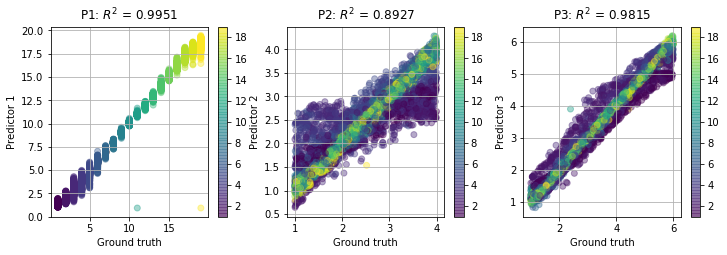

10 [0.99507326 0.89271956 0.98152407]


In [93]:
y_out = cpredictor.predict(z_train, steps = 1)

r2 = np.zeros((3))

plt.figure(figsize=(12, 3.5))
for i in range(num_predictors):
    plt.subplot(1,num_predictors, i+1)
    r2[i] = rsq(y_train[:,i], y_out[:,i])
    plt.scatter(y_train[:,i], y_out[:,i], c=y_train[:,0],
                alpha=.4, cmap='viridis')
    plt.xlabel('Ground truth')
    plt.ylabel('Predictor ' + str(i+1))
    plt.title("P" + str(i+1) + ": $R^2$ = " + str(round(r2[i],4)))
    plt.grid()
    plt.colorbar()
plt.show()

print(latent_dim,r2)

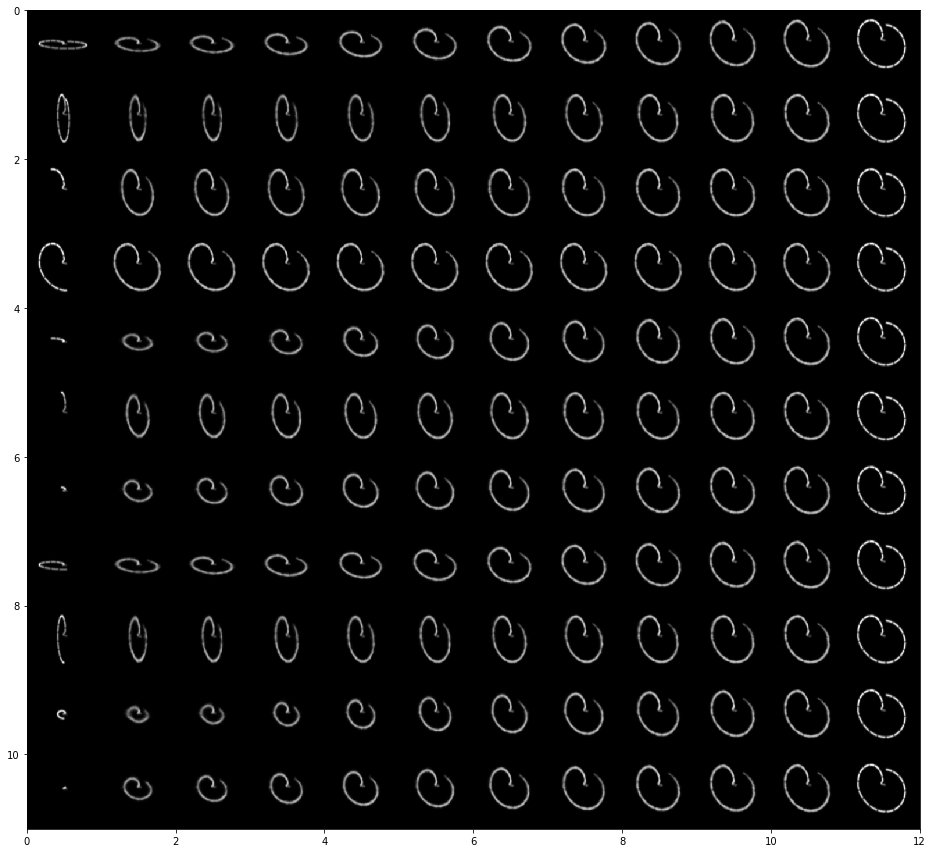

In [94]:
#make semantic test across z space using x_cal, y_cal, interpolating linearly between z
steps = 11
x_dec = []
c_dec = []    

for h in range(1,calnum_images):
    samples = [0,h] #index for sample image
    myz = []
    for i in samples:
        z = vae.encoder.predict(x_cal[i].reshape((1,img_dim,img_dim,1)), batch_size=1)
        myz.append(z)

    for k in range(steps+1):
        mynewz = k/steps*myz[0]+(1-k/steps)*myz[1]
        if k == 0:
            x_dec.append(x_cal[i].reshape((1,img_dim,img_dim,1)))
        elif k == steps:
            x_dec.append(x_cal[0].reshape((1,img_dim,img_dim,1)))
        else:
            x_dec.append(vae.decoder.predict(mynewz))
            #c_dec.append(cpredictor.predict(mynewz))

x_dec = np.array(x_dec)
x_dec = x_dec.reshape(calnum_images-1,steps+1,img_dim, img_dim)

fig, ax = plt.subplots(figsize = (16,18))
ax.imshow(np.block(list(map(list, x_dec))), 
    cmap='gray', interpolation='none', 
    extent=([0,steps+1,calnum_images-1,0]))
ax.set_aspect(1)
plt.show()
c_dec = np.array(c_dec)


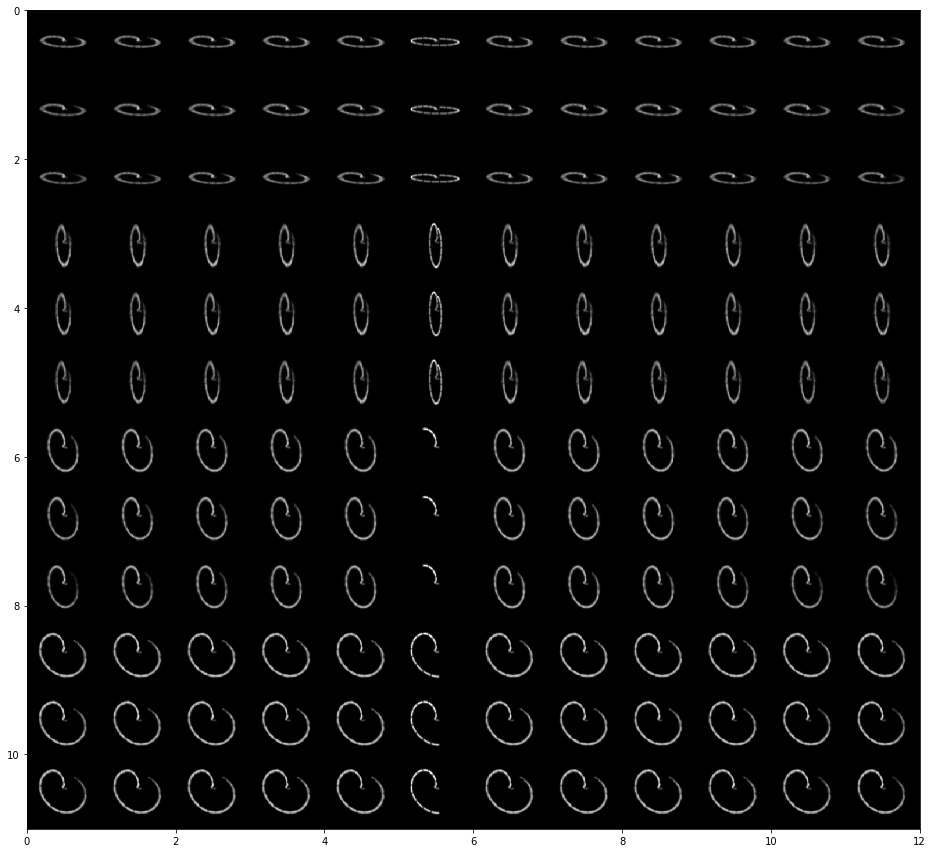

In [95]:
#make semantic test across z space using x_cal, y_cal, moving orthoganally along z, for samples 1-4, for len(modes) z directions
steps = 11
x_dec = []
c_dec = []    
zr = 0.2
modes = [4,7,9]

for h in range(1,5):
    for j in modes:
        z = vae.encoder.predict(x_cal[h].reshape((1,img_dim,img_dim,1)), batch_size=1)
        zt = z[0][j]
        for k in range(steps+1):
            if k == (steps - 1) / 2:
                x_dec.append(x_cal[h].reshape((1,img_dim,img_dim,1)))
            else:
                z[0][j] = zt + zr * (k - (steps - 1) / 2)
                x_dec.append(vae.decoder.predict(z))
                c_dec.append(cpredictor.predict(z))
                
x_dec = np.array(x_dec)
x_dec = x_dec.reshape(4*len(modes),steps+1,img_dim, img_dim)

fig, ax = plt.subplots(figsize = (16,6*len(modes)))
ax.imshow(np.block(list(map(list, x_dec))), 
    cmap='gray', interpolation='none', 
    extent=([0,steps+1,calnum_images-1,0]))
ax.set_aspect(1)
plt.show()
c_dec = np.array(c_dec)


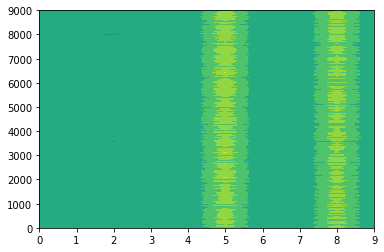

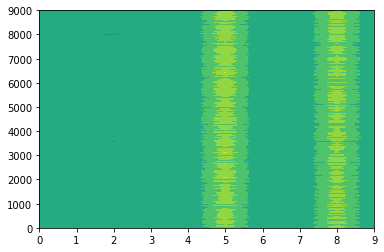

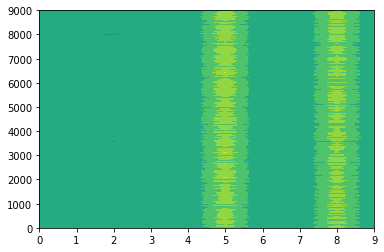

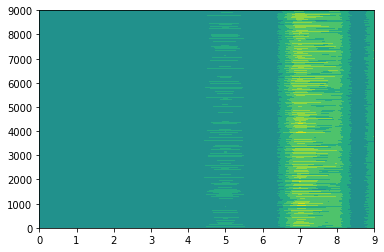

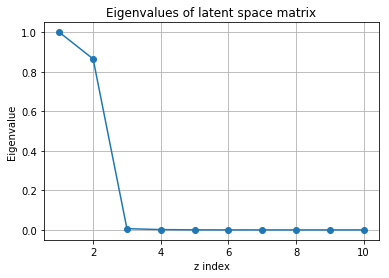

M - Z = 0 (+/-1.0e-03 x Z):  True
[1. 2.]


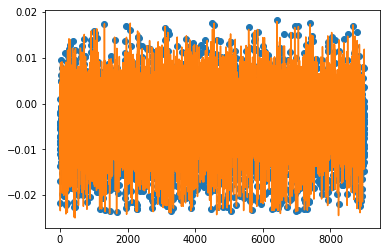

In [96]:
data = z_train

# Full SVD: results that the matrices are not full
# s are the singular values => They need to be squared to get the eigenvalues

u, lam, v = np.linalg.svd(data)

number_eigval = range(1, len(lam) + 1)
# 
plt.figure()
plt.contourf(data)

# %%
M = np.dot(u[:, :len(lam)] * lam, v)

plt.figure()
plt.contourf(M)

# Check if relative difference smaller than 1e-3
np.allclose(data, M, rtol=1e-3)
# %%

u_r, lam_r, v_red = np.linalg.svd(data, full_matrices=False)

M_r = np.dot(u_r * lam_r, v_red)

plt.figure()
plt.contourf(M_r)
np.allclose(data, M_r, rtol=1e-3)
# %%
M = np.zeros(data.shape)

for i in range(v.shape[1]):
    ui, vi = u[:, i], v[:, i]
    ui = ui.reshape(u.shape[0], 1)
    vi = vi.reshape(1, v.shape[0])
    M = M + (lam[i] * np.dot(ui, vi))
plt.figure()
plt.contourf(M)
# %%
plt.figure()
plt.plot(number_eigval, lam**2/lam[0]**2, 'o-')
plt.grid()
plt.xlabel("z index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of latent space matrix")
plt.show()


def diagonaliseZ(data_z, check_tol=None, full_matrices=False):
    """"
    Take a Z space matrix (m x n), with m input size and n Z-space size and returns
    U, lambda and V.T matrices of SVD decomposition. Can also check how close it is to the
    orginal matrix using the 'check_tol' parameter
    @param data_z: Z matrix
    @param check_tol: relative of the difference to check
    @param full_matrices: return full matrices, default False
    :return U matrix (m x n) (or (m x m) if full_matrices=True), vector of singular values and V matrix (n x n)
    """
    u_r, lam_r, v_r = np.linalg.svd(data_z, full_matrices=full_matrices)

    M_r = np.dot(u_r * lam_r, v_r)

    if not check_tol == None:
        print('M - Z = 0 (+/-%.1e x Z): '%check_tol, np.allclose(data, M_r, rtol=1e-3))

    return u_r, lam_r, v_r


u, lam, v = diagonaliseZ(data, check_tol=1e-3)

def changeOrth(data_z, index, n_val=[], n_val_delta=[], n_val_r=[], **kwargs):
    """"
    Change the singular value (SV) 'index' by a given quantity. This can also be relative or a delta. 
    Order is priority. 
    @param data_z: Z matrix
    @param index: index of the SV to change
    @param n_val: value that will replace the SV
    @param n_val_delta: delta to change for the given SV
    @param n_val_r: relative change of the given SV
    :return Z matrix with the demanded change
    """
    u_t, l_t, v_t = diagonaliseZ(data_z, **kwargs)

    if n_val != []:
        l_t[index] = n_val
    elif n_val_delta != []:
        l_t[index] = l_t[index] + n_val_delta
    elif n_val_r != []:
        l_t[index] = l_t[index] + l_t[index] * n_val_delta

    return np.dot(u_t * l_t, v_t)

def changeZ(data_z, index, n_val=[], n_val_delta=[], n_val_r=[], **kwargs):
    """"
    Change the singular value (SV) 'index' by a given quantity. This can also be relative or a delta. 
    Order is priority. 
    @param data_z: Z matrix
    @param index: index of the SV to change
    @param n_val: value that will replace the SV
    @param n_val_delta: delta to change for the given SV
    @param n_val_r: relative change of the given SV
    :return Z matrix with the demanded change
    """
    data_z_temp = np.copy(data_z)
    for i in range(data_z_temp.shape[0]):
        if n_val != []:
            data_z_temp[i, index[0]:index[1]] = n_val
        elif n_val_delta != []:
            data_z_temp[i, index[0]:index[1]] = data_z_temp[i, index[0]:index[1]] + n_val_delta
        elif n_val_r != []:
            data_z_temp[i, index[0]:index[1]] = data_z_temp[i, index[0]:index[1]] + data_z_temp[i, index[0]:index[1]] * n_val_delta

    return data_z_temp

M = changeOrth(data, [0, 1], n_val_delta=[1, 10])

M_red = np.dot(u[:, :3] * lam[:3], v[:3, :3])

plt.figure()
plt.plot(data[:, 0], 'o')
plt.plot(M_red[:, 0])

z_n = changeZ(data, (0, 2), n_val_delta=[1, 2])
print(z_n[0, 0:2] - data[0, 0:2])

In [ ]:
## 

plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test[:, 1],alpha=.4, cmap='viridis')
#plt.scatter(z_train[:, 0], z_train[:, 1])
plt.xlabel('Z[0]')
plt.ylabel('Z[1]')
plt.colorbar()
plt.grid()
plt.show()


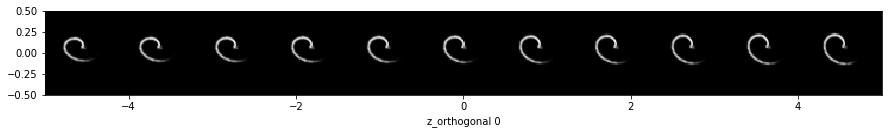

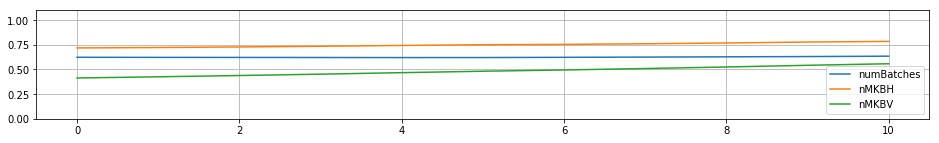

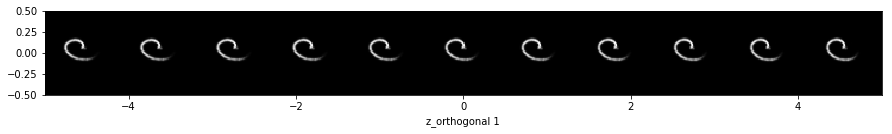

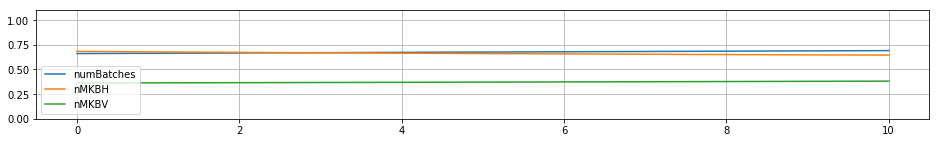

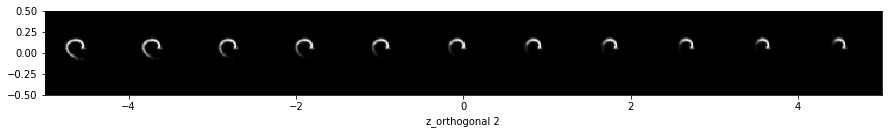

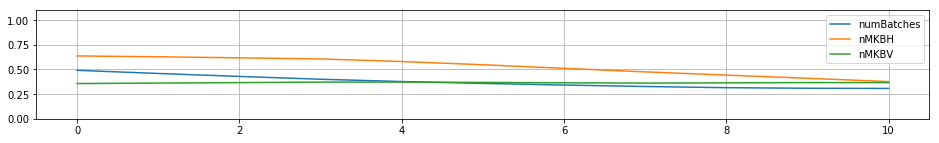

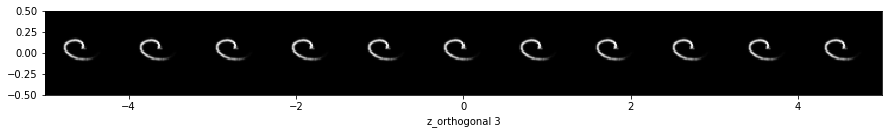

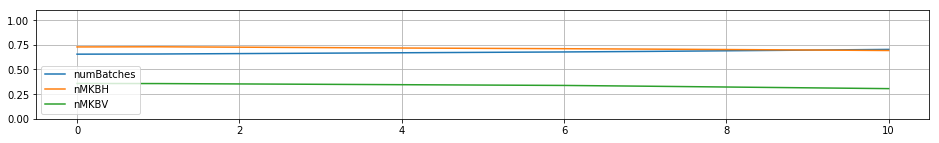

In [25]:
#### Plot images generated from orthogonalised z space
mydata = vae.encoder.predict(x_test, batch_size=batch_size)
test_img = 6
n = 11
maxbase = 3
normp = (20,4,6)

for j in range(maxbase+1):
    bases = [j]
    x_decoded = []
    c_decoded = []
    for i in range(n):
        M_new = changeOrth(mydata, bases, # v in image    h in image
                           n_val_delta=[(-i-(n-1)/2)*2])[test_img:test_img+1, :]
        x_decoded.append(vae.decoder.predict(M_new))
        c_decoded.append(cpredictor.predict(M_new))
    x_decoded = np.array(x_decoded)
    x_decoded = x_decoded.reshape(1,n,img_dim, img_dim)

    fig, ax = plt.subplots(figsize = (15,4))
    ax.imshow(np.block(list(map(list, x_decoded))), 
        cmap='gray', interpolation='none', 
        extent=([-(n-1)//2,(n-1)//2,-0.5,0.5]))
    ax.set_aspect(1)
    plt.xlabel('z_orthogonal ' + str(j))
    plt.show()
    c_decoded = np.array(c_decoded)
    
    plt.figure(figsize = (16,2))
    for k in range(num_predictors):
        plt.plot(c_decoded[:,0][:,k]/normp[k],'-',label=preds[k])
    plt.ylim(0,1.1)
    plt.legend()
    plt.grid()
    plt.show()



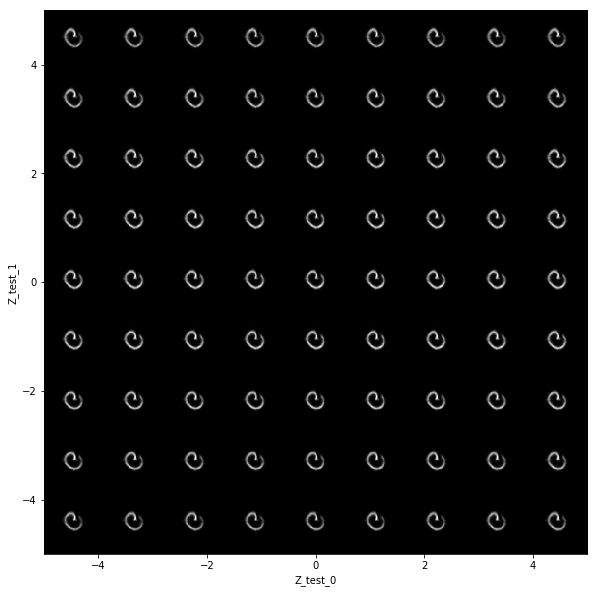

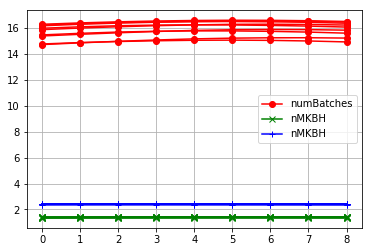

In [97]:
#### Plot images generated from orthogonalised z space
#z_test = encoder.predict(x_test, batch_size=batch_size)
mydata = vae.encoder.predict(x_test, batch_size=batch_size)
#mydata = data
test_img = 1
n = 9
bases = [5,8]

x_decoded = []
c_decoded = []
for i in range(n):
    for j in range(n):
        M_new = changeOrth(mydata, bases, # v in image    h in image
                           n_val_delta=[(i-(n-1)/2)*10,(j-(n-1)/2)*10])[test_img:test_img+1, :]
        x_decoded.append(vae.decoder.predict(M_new))
        c_decoded.append(cpredictor.predict(vae.encoder.predict(vae.decoder.predict(M_new))))
x_decoded = np.array(x_decoded)
x_decoded = x_decoded.reshape(n,n, img_dim, img_dim)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.block(list(map(list, x_decoded))), 
cmap='gray', interpolation='none', 
extent=[-5,5,-5,5])
ax.set_aspect(1)
plt.xlabel('Z_test_0')
plt.ylabel('Z_test_1')
plt.show()
c_decoded = np.array(c_decoded)

plt.figure()
for i in range(n):
    if i == 0:
        plt.plot(c_decoded[i*n:((i+1)*n),0][:,0],'ro-',label=preds[0])
        plt.plot(c_decoded[i*n:((i+1)*n),0][:,1],'gx-',label=preds[1])
        plt.plot(c_decoded[i*n:((i+1)*n),0][:,2],'b+-',label=preds[1])
    else:
        plt.plot(c_decoded[i*n:((i+1)*n),0][:,0],'ro-')
        plt.plot(c_decoded[i*n:((i+1)*n),0][:,1],'gx-')
        plt.plot(c_decoded[i*n:((i+1)*n),0][:,2],'b+-')        
plt.legend()
plt.grid()
plt.show()



[[ 2.8466247e-04 -1.0731397e-03 -2.0840898e-02 -3.1110656e-02
   1.7758310e-03 -4.4585833e-01 -2.7006380e-02  1.3792291e-03
   5.2650350e-01 -1.7235577e-03]]
(81, 1, 3)


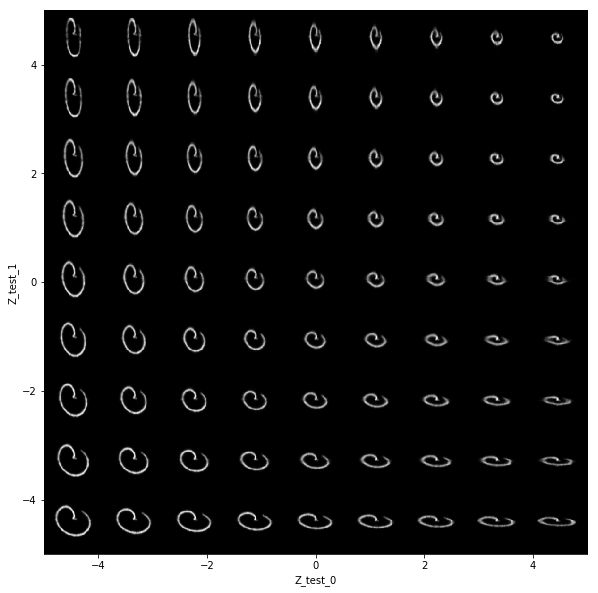

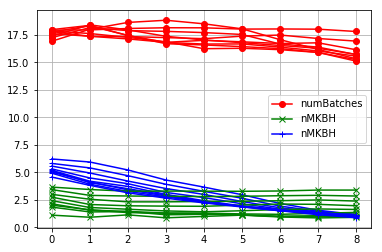

In [102]:
"""
Plot images generated from regular z space
"""
mydata = vae.encoder.predict(x_test, batch_size=batch_size)
d = 0.1
un_grid = np.dstack(np.meshgrid(np.linspace(d, 1-d, n)))
#un_grid = np.dstack(np.meshgrid(np.linspace(d, 1-d, n),
#                               np.linspace(d, 1-d, n)))
zn_grid = norm.ppf(un_grid)[0]

N_new = mydata[test_img:test_img+1, :]
print(N_new)

N0 = [N_new[0,bases[0]],N_new[0,bases[1]]]
ir = 10
jr = 10

xn_decoded = []
cn_decoded = []

for i in range(n):
    N_new[0,bases[0]] = N0[0]+zn_grid[i]
    for j in range(n):
        N_new[0][bases[1]] = N0[1]+zn_grid[j]
        #print(N_new[0],bases[0],N_new[0],bases[1])
        xn_decoded.append(vae.decoder.predict(N_new))
        cn_decoded.append(cpredictor.predict(vae.encoder.predict(vae.decoder.predict(N_new))))
xn_decoded = np.array(xn_decoded)
xn_decoded = xn_decoded.reshape(n,n, img_dim, img_dim)
#print(N_new)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.block(list(map(list, xn_decoded))), 
cmap='gray', interpolation='none', 
extent=[-5,5,-5,5])
ax.set_aspect(1)
plt.xlabel('Z_test_0')
plt.ylabel('Z_test_1')

cn_decoded = np.array(cn_decoded)
print(cn_decoded.shape)

plt.figure()
for i in range(n):
    if i == 0:
        plt.plot(cn_decoded[i*n:((i+1)*n),0][:,0],'ro-',label=preds[0])
        plt.plot(cn_decoded[i*n:((i+1)*n),0][:,1],'gx-',label=preds[1])
        plt.plot(cn_decoded[i*n:((i+1)*n),0][:,2],'b+-',label=preds[1])
    else:
        plt.plot(cn_decoded[i*n:((i+1)*n),0][:,0],'ro-')
        plt.plot(cn_decoded[i*n:((i+1)*n),0][:,1],'gx-')
        plt.plot(cn_decoded[i*n:((i+1)*n),0][:,2],'b+-')        
plt.legend()
plt.grid()
plt.show()